In this project I will analize housing market in the New York City

Hypothesis: price of house in the NYC dpend on several key factors: number of beds/baths, squere footage, and neighborhood. The more beds/baths/squre foot the apertment has the higher the price is. Also the higher median price of the apartments in the neighborhood the higher the price is.

In [1015]:
import geopandas as gpd
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from shapely.geometry import Point
from random import randint
import seaborn as sns
from sklearn import linear_model
from sklearn import svm
from sklearn.ensemble import HistGradientBoostingClassifier
import pickle

Loading data about property in the NYC and geography of the NYC

In [1016]:
nyc_map = gpd.read_file("geodata.geojson")
nyc_map = nyc_map.drop(columns=['boroughCode', '@id'])

In [1017]:
nyc_map.head()

,neighborhood,borough,geometry
0,Allerton,Bronx,"POLYGON ((-73.8486 40.87167, -73.84582 40.8702..."
1,Alley Pond Park,Queens,"POLYGON ((-73.74333 40.73888, -73.74371 40.739..."
2,Arden Heights,Staten Island,"POLYGON ((-74.16983 40.56108, -74.16982 40.561..."
3,Arlington,Staten Island,"POLYGON ((-74.15975 40.64142, -74.15998 40.641..."
4,Arrochar,Staten Island,"POLYGON ((-74.06078 40.59319, -74.06079 40.593..."


Cleaning dataset of prices

In [1018]:
data = pd.read_csv("NY-House-Dataset.csv")
data = data.drop(columns=['BROKERTITLE', 'ADDRESS', 'TYPE', 'STATE', 'MAIN_ADDRESS', 'ADMINISTRATIVE_AREA_LEVEL_2', 'LOCALITY', 'SUBLOCALITY', 'STREET_NAME', 'LONG_NAME', 'FORMATTED_ADDRESS'])
data = data.dropna()
data = data[data.PRICE < 30000001]
data = data[data.BEDS < 16]
data = data[data.BATH < 11]
data = data[data.PROPERTYSQFT < 15001]
data = data[data.PRICE > 0]
data = data[data.BEDS > 0]
data = data[data.BATH > 0]
data = data[data.PROPERTYSQFT > 0]
data = data.drop(1279)

Assigning neighborhood to each property

In [1019]:
neighborhood_id = dict()
borough = dict()
neighborhood_id[np.nan] = np.nan

In [1020]:
neighborhood = []
prices = dict()
for idx in range(data.shape[0]):
    ans = np.nan
    point = Point(data.iloc[idx]['LONGITUDE'], data.iloc[idx]['LATITUDE'])
    for idx1 in range(nyc_map.shape[0]):
        polygon = nyc_map.iloc[idx1]['geometry']
        if (polygon.contains(point)) :
            ans = nyc_map.iloc[idx1]['neighborhood']
            break
    neighborhood.append(ans)
    if (ans != np.nan):
        try:
            prices[ans].append(data.iloc[idx]['PRICE'])
        except:
            prices[ans] = []
            prices[ans].append(data.iloc[idx]['PRICE'])

Calculating median price for each neighborhood

In [1021]:
medianprices = []
median = []
for idx in range(nyc_map.shape[0]):
    try:
        prices[nyc_map.iloc[idx]['neighborhood']].sort()
        ln = len(prices[nyc_map.iloc[idx]['neighborhood']])
        medianprices.append((prices[nyc_map.iloc[idx]['neighborhood']][ln // 2], nyc_map.iloc[idx]['neighborhood']))
        median.append(prices[nyc_map.iloc[idx]['neighborhood']][ln // 2])
    except:
        rnd = randint(200000, 500000)
        medianprices.append((rnd, nyc_map.iloc[idx]['neighborhood']))
        median.append(rnd)
medianprices.sort()
for idx in range(len(medianprices)):
    neighborhood_id[medianprices[idx][1]] = idx
    

In [1022]:
id_to_n = dict()
for idx in range(len(neighborhood)):
    id_to_n[neighborhood_id[neighborhood[idx]]] = neighborhood[idx]
    neighborhood[idx] = neighborhood_id[neighborhood[idx]]

In [1023]:
data = data.assign(neighborhood=neighborhood)
data = data.drop(columns=['LATITUDE', 'LONGITUDE'])
data = data.dropna()
nyc_map = nyc_map.assign(median_price=median)

In [1024]:
for idx in range(nyc_map.shape[0]):
    borough[nyc_map.iloc[idx]['neighborhood']] = nyc_map.iloc[idx]['borough']
nyc_map = nyc_map.drop(columns=['borough'])
nyc_map.head()

,neighborhood,geometry,median_price
0,Allerton,"POLYGON ((-73.8486 40.87167, -73.84582 40.8702...",650000.0
1,Alley Pond Park,"POLYGON ((-73.74333 40.73888, -73.74371 40.739...",261769.0
2,Arden Heights,"POLYGON ((-74.16983 40.56108, -74.16982 40.561...",750000.0
3,Arlington,"POLYGON ((-74.15975 40.64142, -74.15998 40.641...",483675.0
4,Arrochar,"POLYGON ((-74.06078 40.59319, -74.06079 40.593...",798000.0


Genral information about dataset (prices, beds, baths, footage)

In [1025]:
data.head()

,PRICE,BEDS,BATH,PROPERTYSQFT,neighborhood
0,315000,2,2.0,1400.000000,257
2,260000,4,2.0,2015.000000,244
3,69000,3,1.0,445.000000,257
5,690000,5,2.0,4004.000000,249
6,899500,2,2.0,2184.207862,226


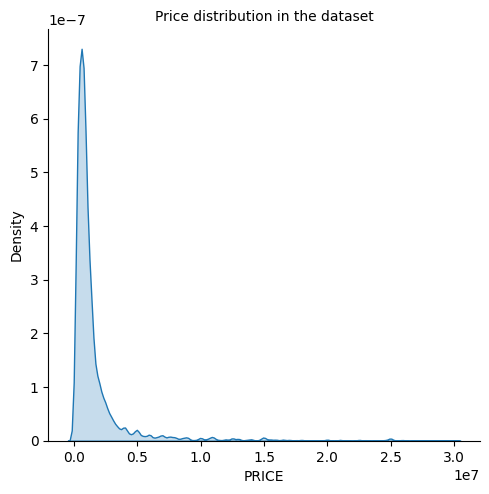

In [1026]:
def show_price() -> None:
    p = sns.displot(data=data['PRICE'].to_frame(), x="PRICE", kind="kde", fill=True, bw_adjust=0.3)
    plt.title('Price distribution in the dataset', fontsize=10)
    plt.show()
show_price()

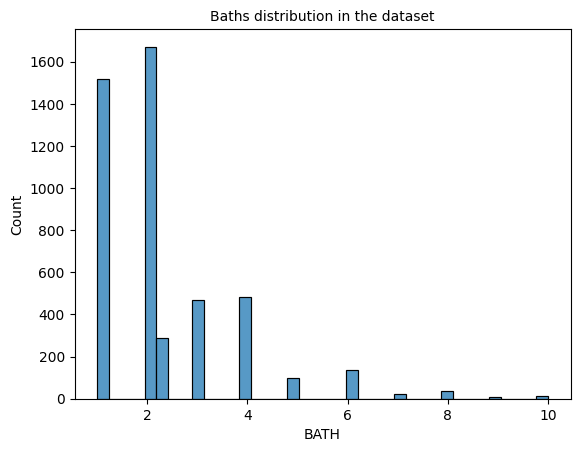

In [1027]:
def show_bath() -> None:
    sns.histplot(data=data['BATH'].to_frame(), x='BATH')
    plt.title('Baths distribution in the dataset', fontsize=10)
    plt.show()

show_bath()

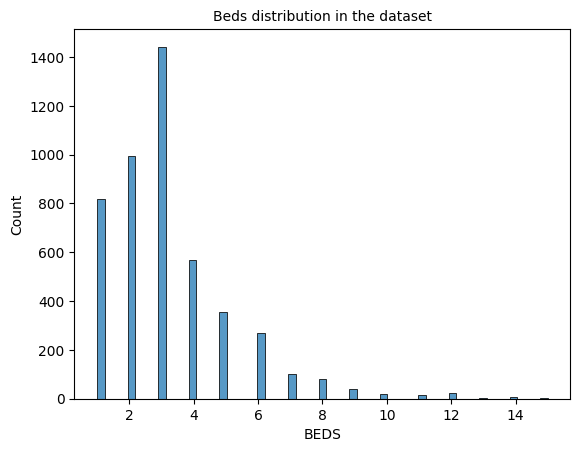

In [1028]:
def show_beds() -> None:
    sns.histplot(data=data['BEDS'].to_frame(), x='BEDS')
    plt.title('Beds distribution in the dataset', fontsize=10)
    plt.show()

show_beds()

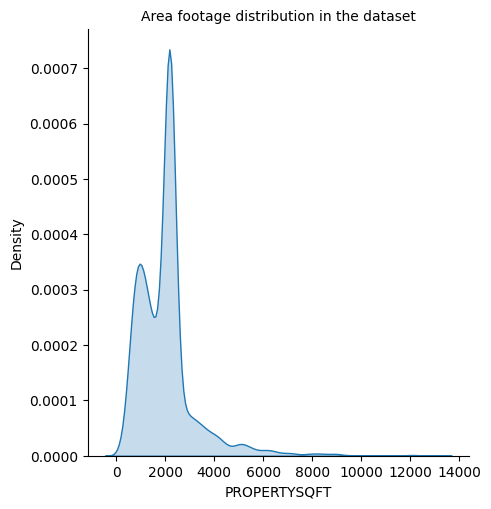

In [1029]:
def show_sqft() -> None:
    sns.displot(data=data['PROPERTYSQFT'].to_frame(), x="PROPERTYSQFT", kind="kde", fill=True)
    plt.title('Area footage distribution in the dataset', fontsize=10)
    plt.show()

show_sqft()

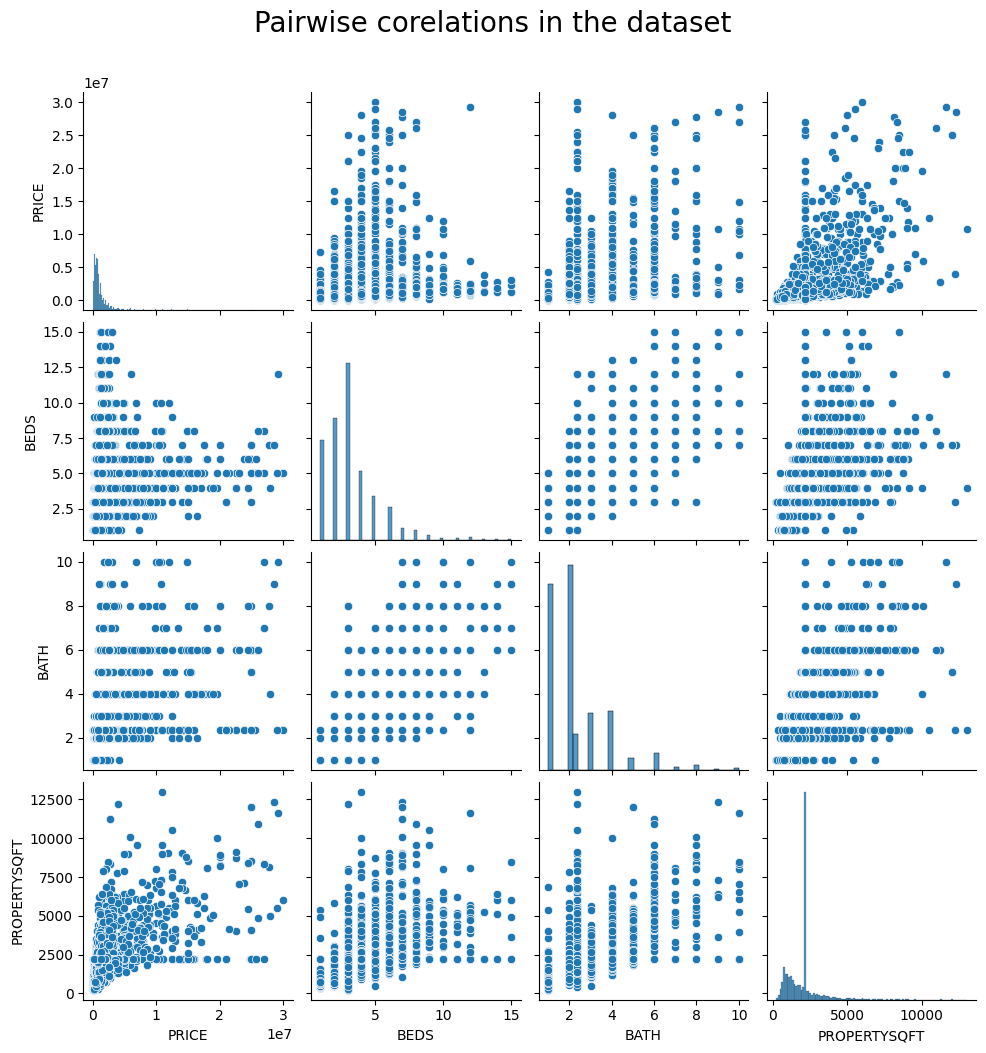

In [1030]:
def show_corelations() -> None:
    p = sns.pairplot(data=data.drop(columns='neighborhood'))
    plt.suptitle('Pairwise corelations in the dataset', fontsize=20, y=1.05)
    plt.show()

show_corelations()

In [1031]:
labels = ['Manhattan', 'Brooklyn', 'Queens', 'Staten Island', 'Bronx']
amount = [0, 0, 0, 0, 0]
neig_bor = dict()
for elem in neighborhood_id.keys():
    if (elem is np.nan):
        continue
    try:
        neig_bor[borough[elem]].append(elem)
    except:
        neig_bor[borough[elem]] = []
        neig_bor[borough[elem]].append(elem)

In [1032]:
for idx in range(len(labels)):
    for elem in neig_bor[labels[idx]]:
        try:
            amount[idx] += len(prices[elem])
        except:
            pass

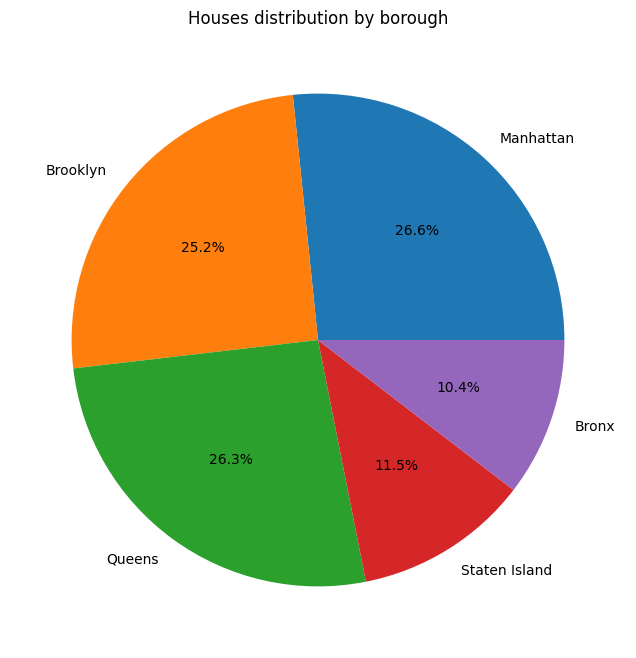

In [1033]:
fig, ax = plt.subplots(figsize=(8, 8))
ax.pie(amount, labels=labels, autopct='%1.1f%%')
plt.title("Houses distribution by borough")
plt.show()

In [1034]:
def show_borough(borough: str) -> None:
    global prices
    global neig_bor
    df = pd.DataFrame()
    df = df.assign(neighborhood=list(neig_bor[borough]))
    count = []
    for elem in neig_bor[borough]:
        try:
            count.append(len(prices[elem]))
        except:
            count.append(1)
    df = df.assign(count=count)
    plt.figure(1, figsize = (20,8))
    plt.title(f'Data ditribution in {borough}', fontsize=20)
    p = sns.barplot(data=df, x='neighborhood', y='count', fill=False, gap=0.1)
    p.tick_params(axis='x', rotation=90)
    plt.show()

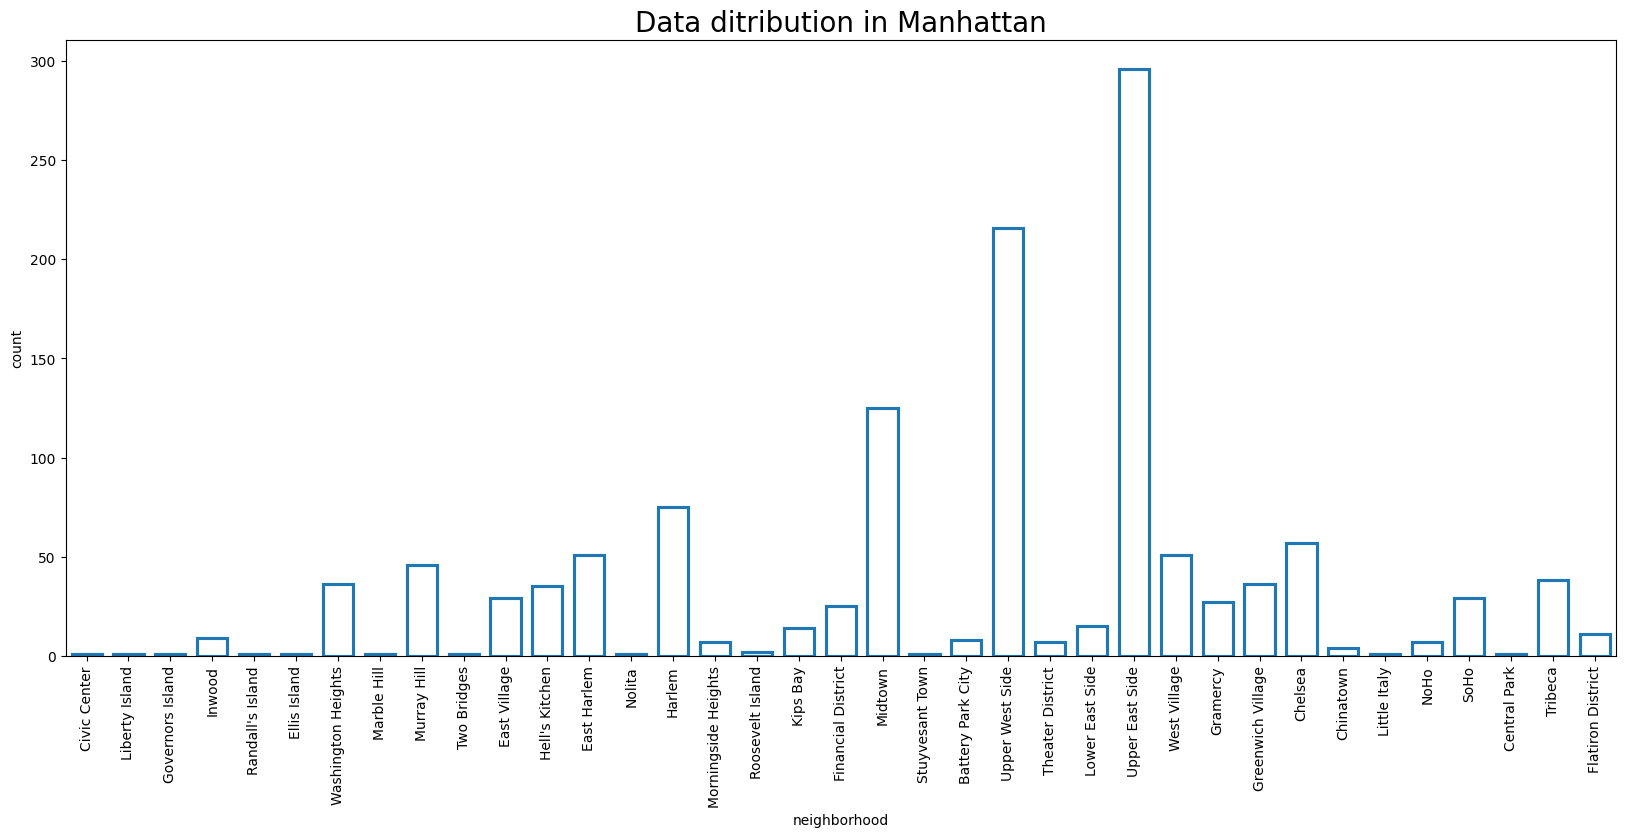

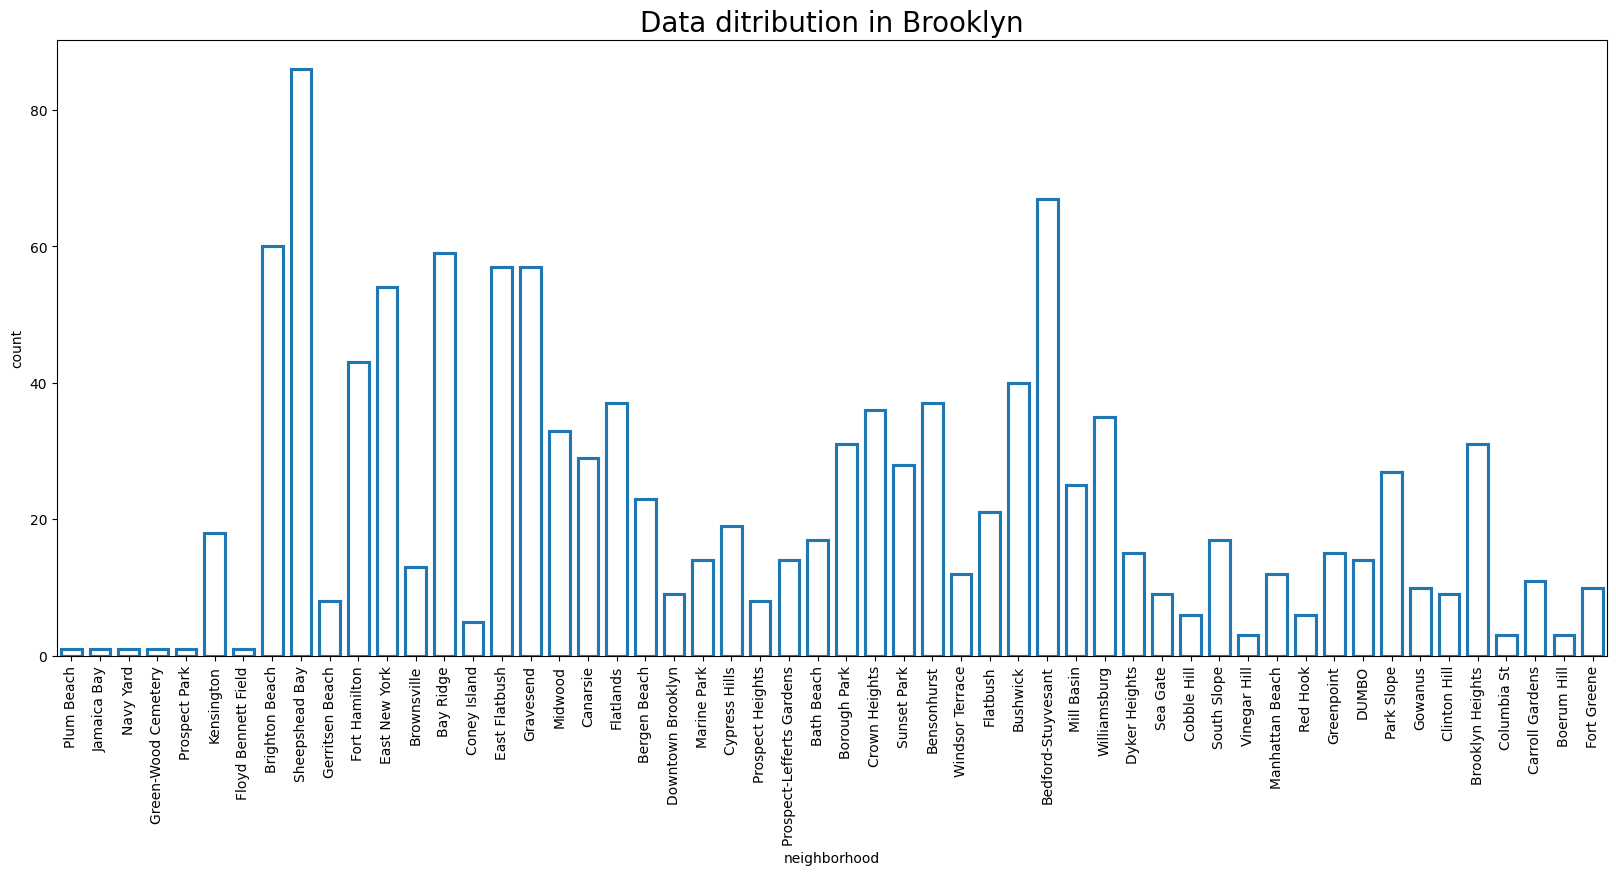

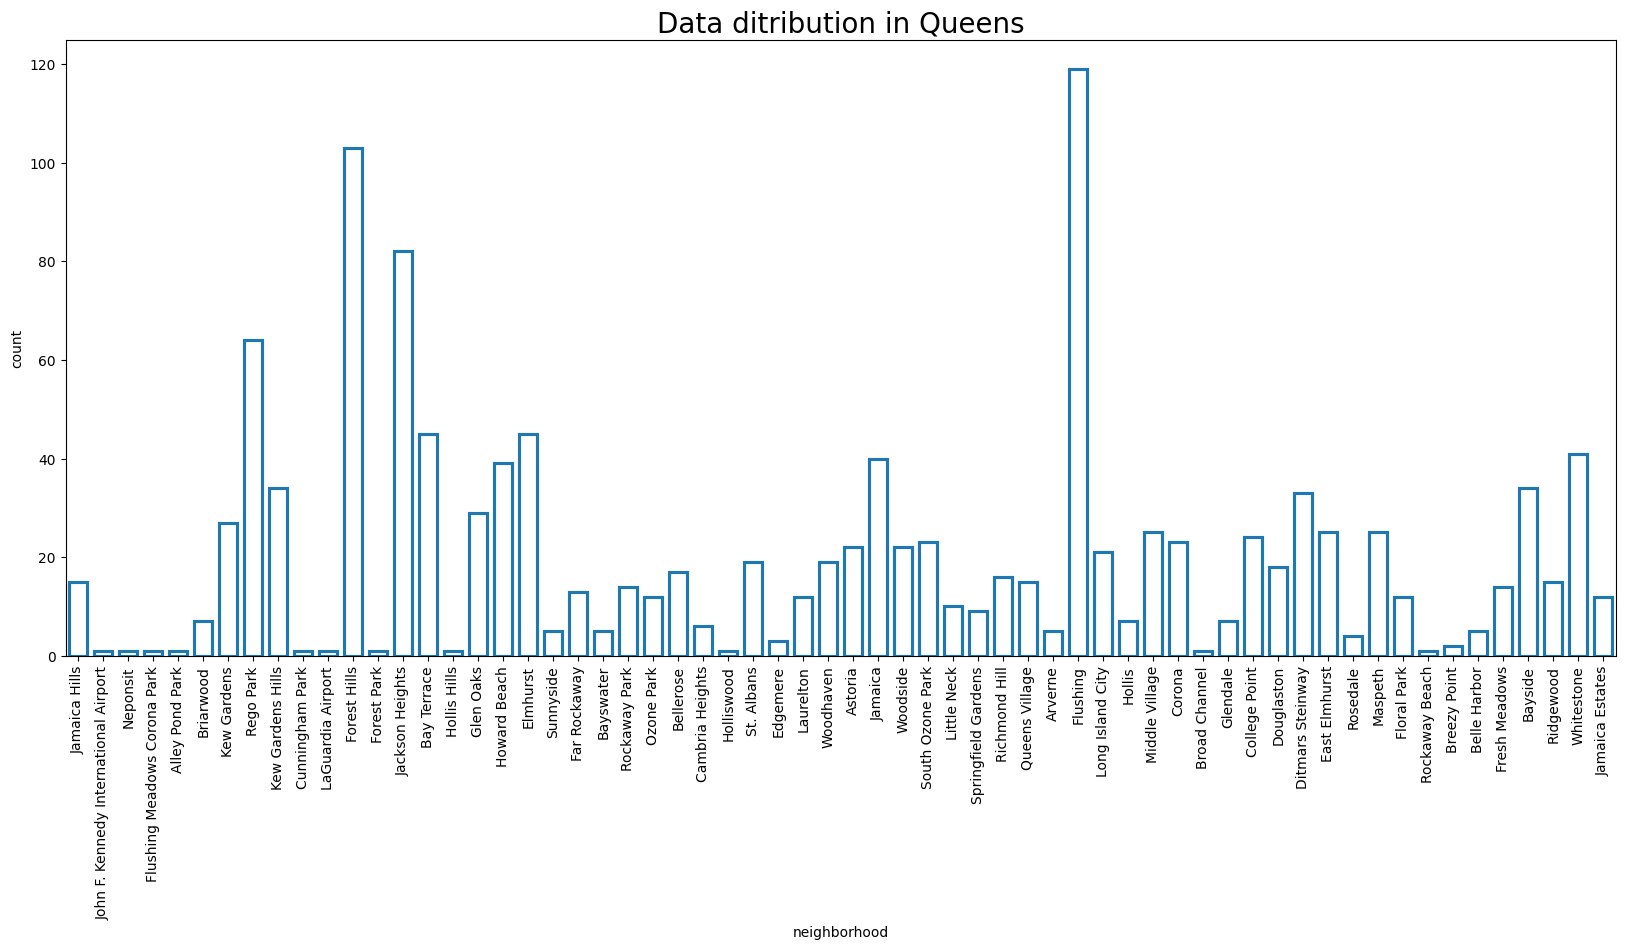

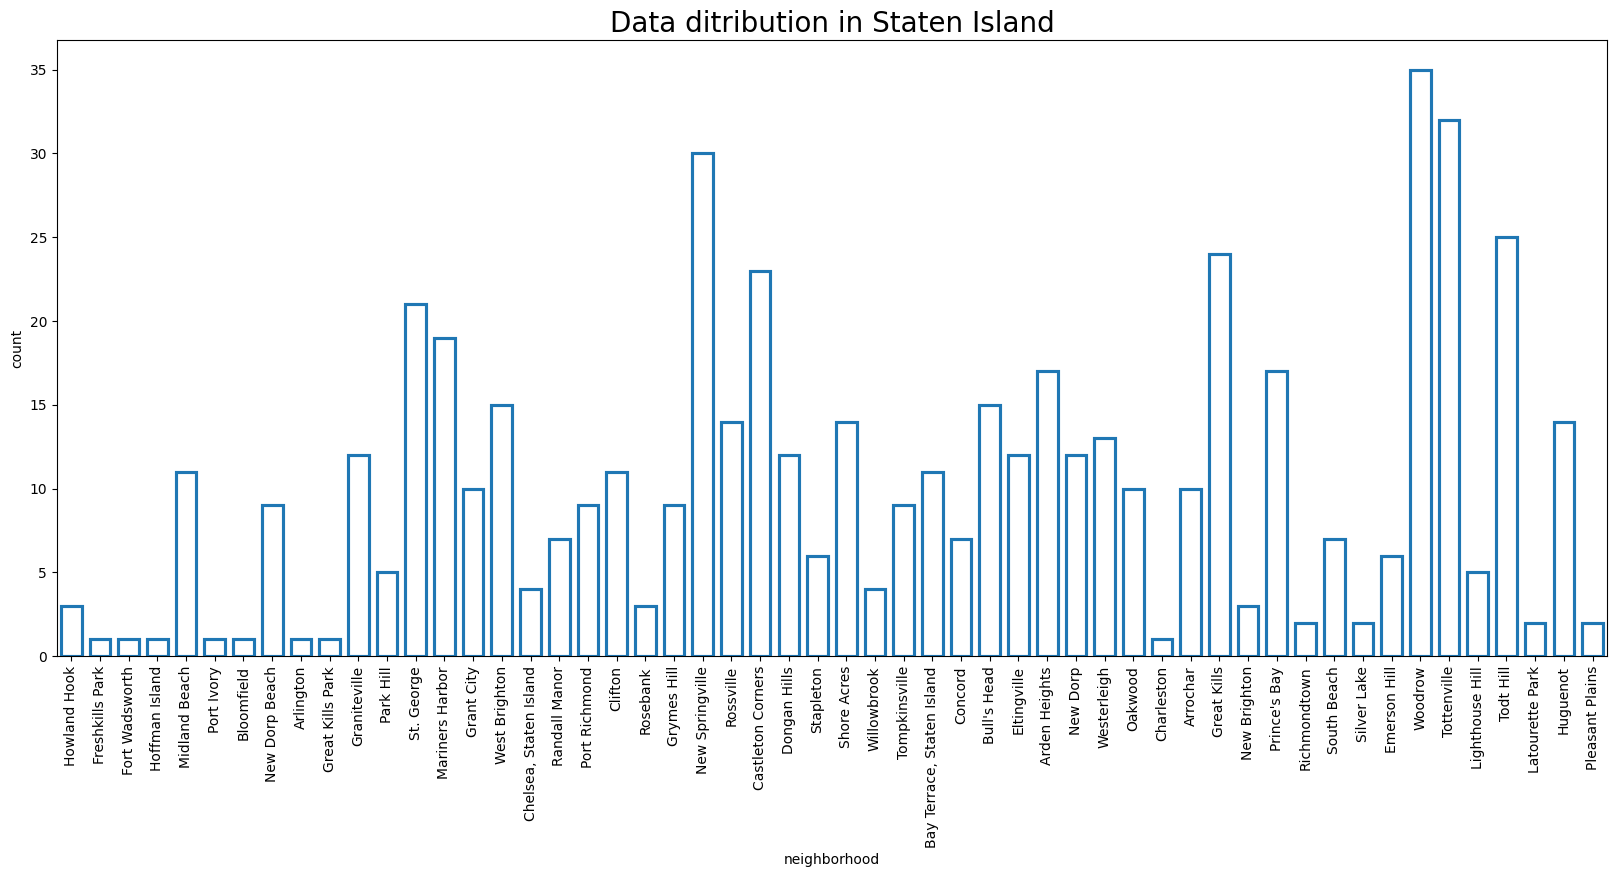

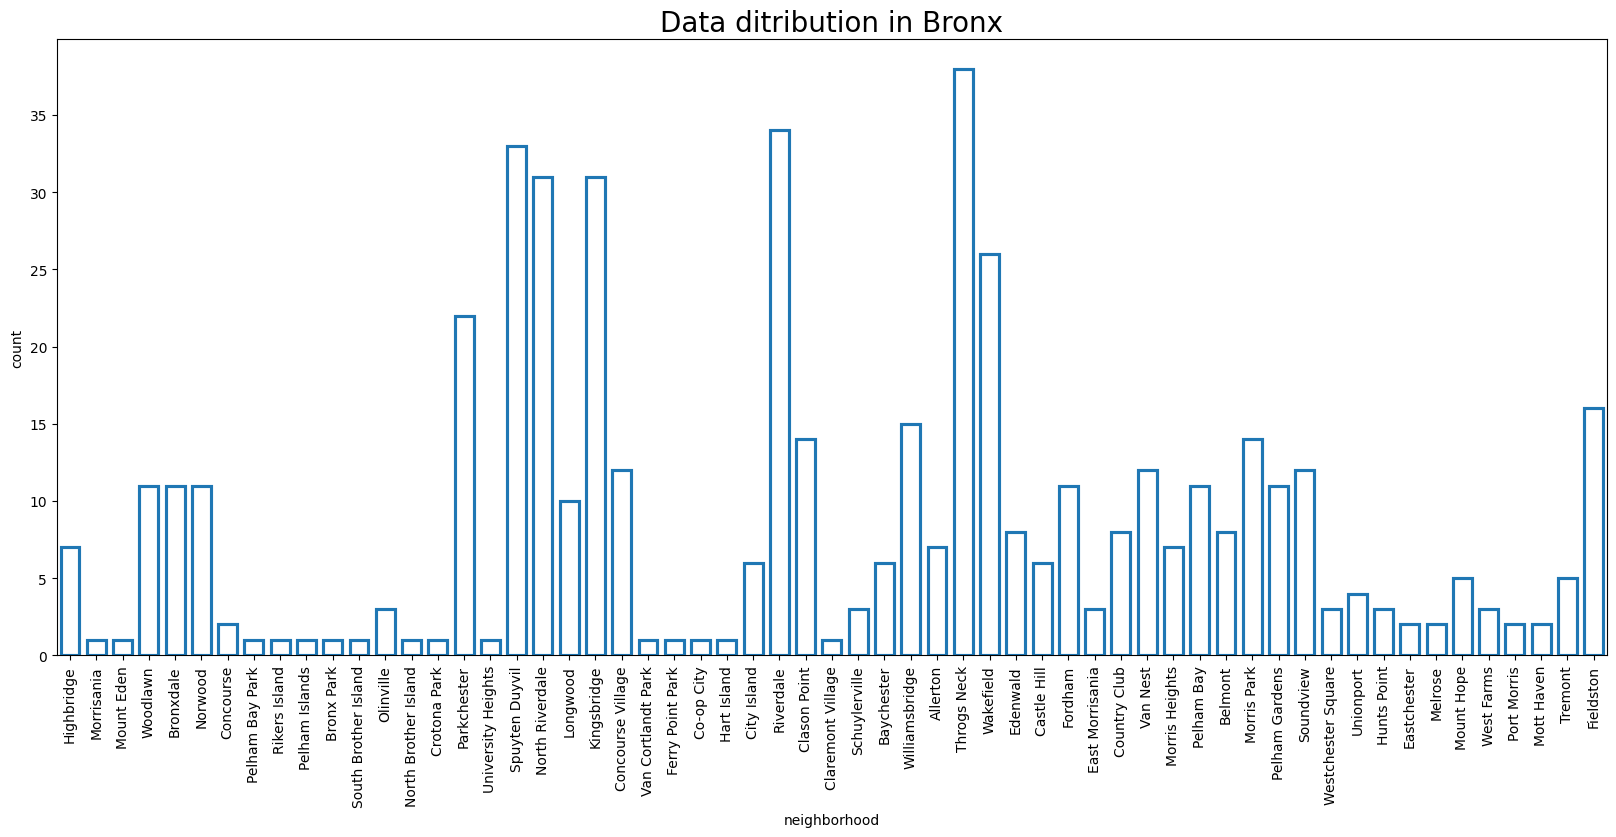

In [1035]:
for bor in labels:
    show_borough(bor)

Overall, there are too much neighborhoods to represent each, that is why in the following analysis, they will be united into boroughs, in which they tend to have relativly close median prices.

A more detailed overview, regarding corelations in dataset

In [1036]:
def price_to_ratio(label: str) -> None:
    global data
    global id_to_n
    global borough
    df = pd.DataFrame()
    br = []
    price = []
    num = []
    for idx in range(data.shape[0]):
        cur = data.iloc[idx]
        br.append(borough[id_to_n[cur['neighborhood']]])
        price.append(cur['PRICE'])
        num.append(cur[label])
    df['borough'] = br
    df['PRICE'] = price
    df[label] = num
    plt.figure(1, figsize = (20,13))
    plt.title(f"Price to {label} corelation by borough", fontsize=20)
    sns.lineplot(data=df, x=label, y="PRICE", hue="borough")
    plt.show()

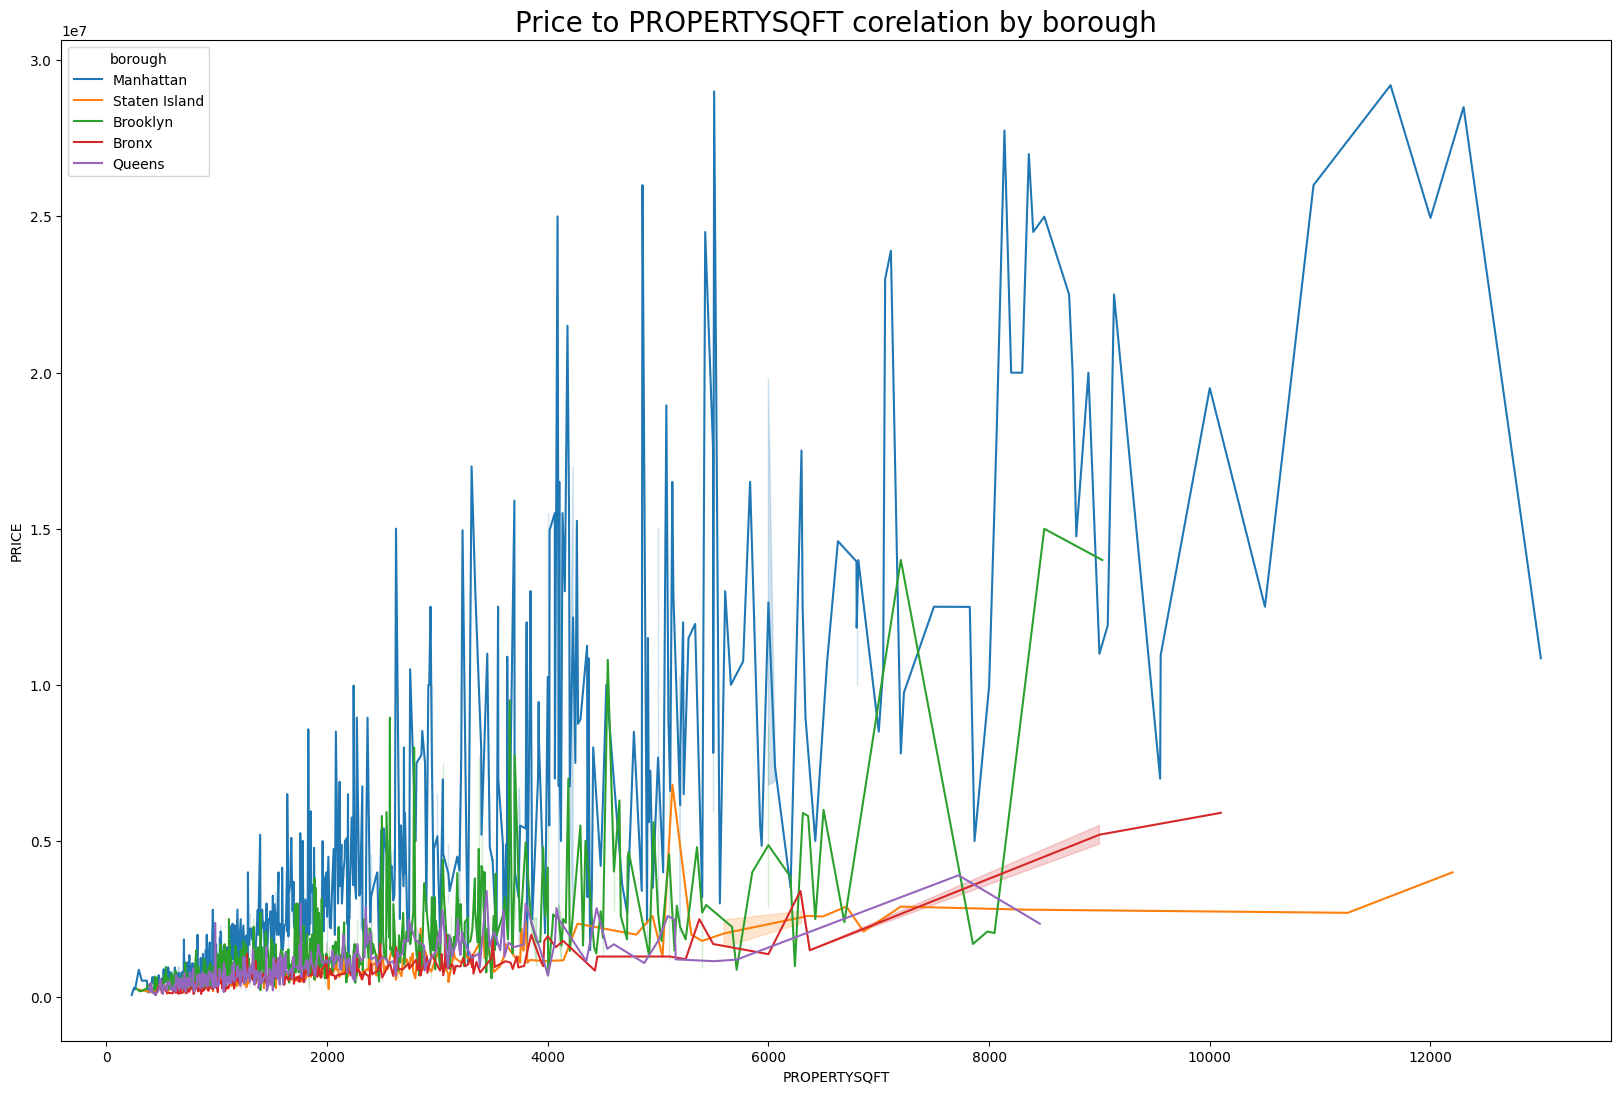

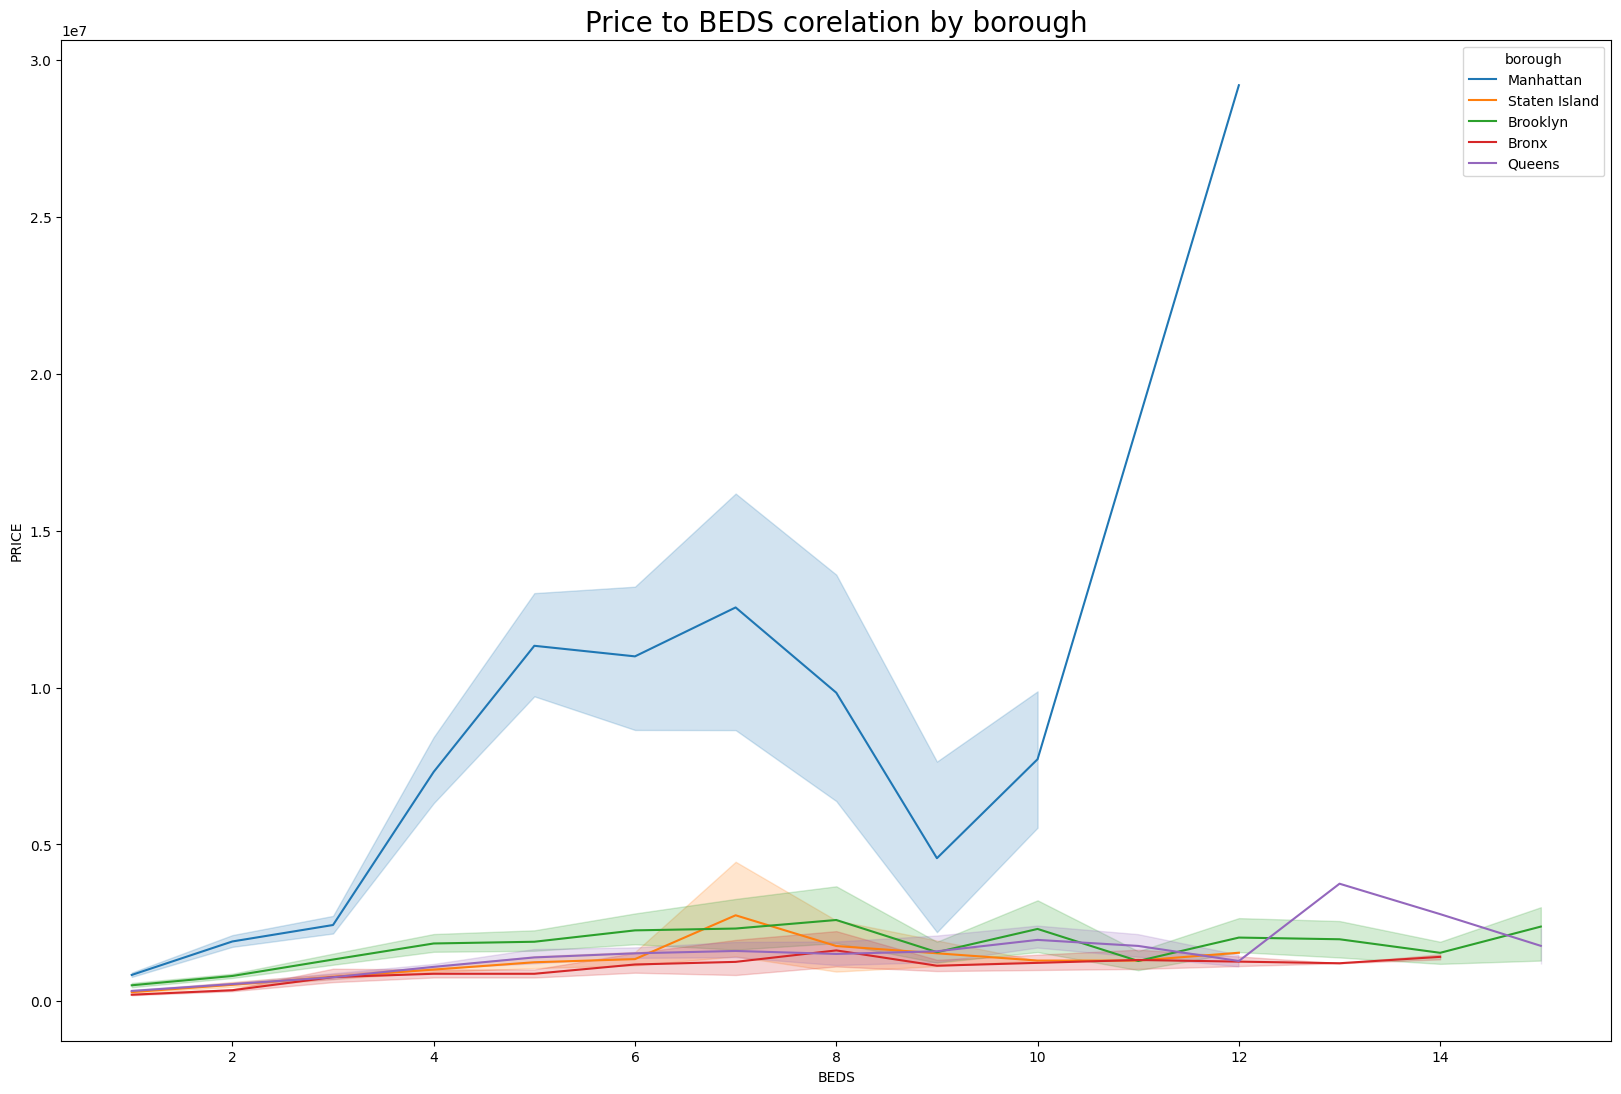

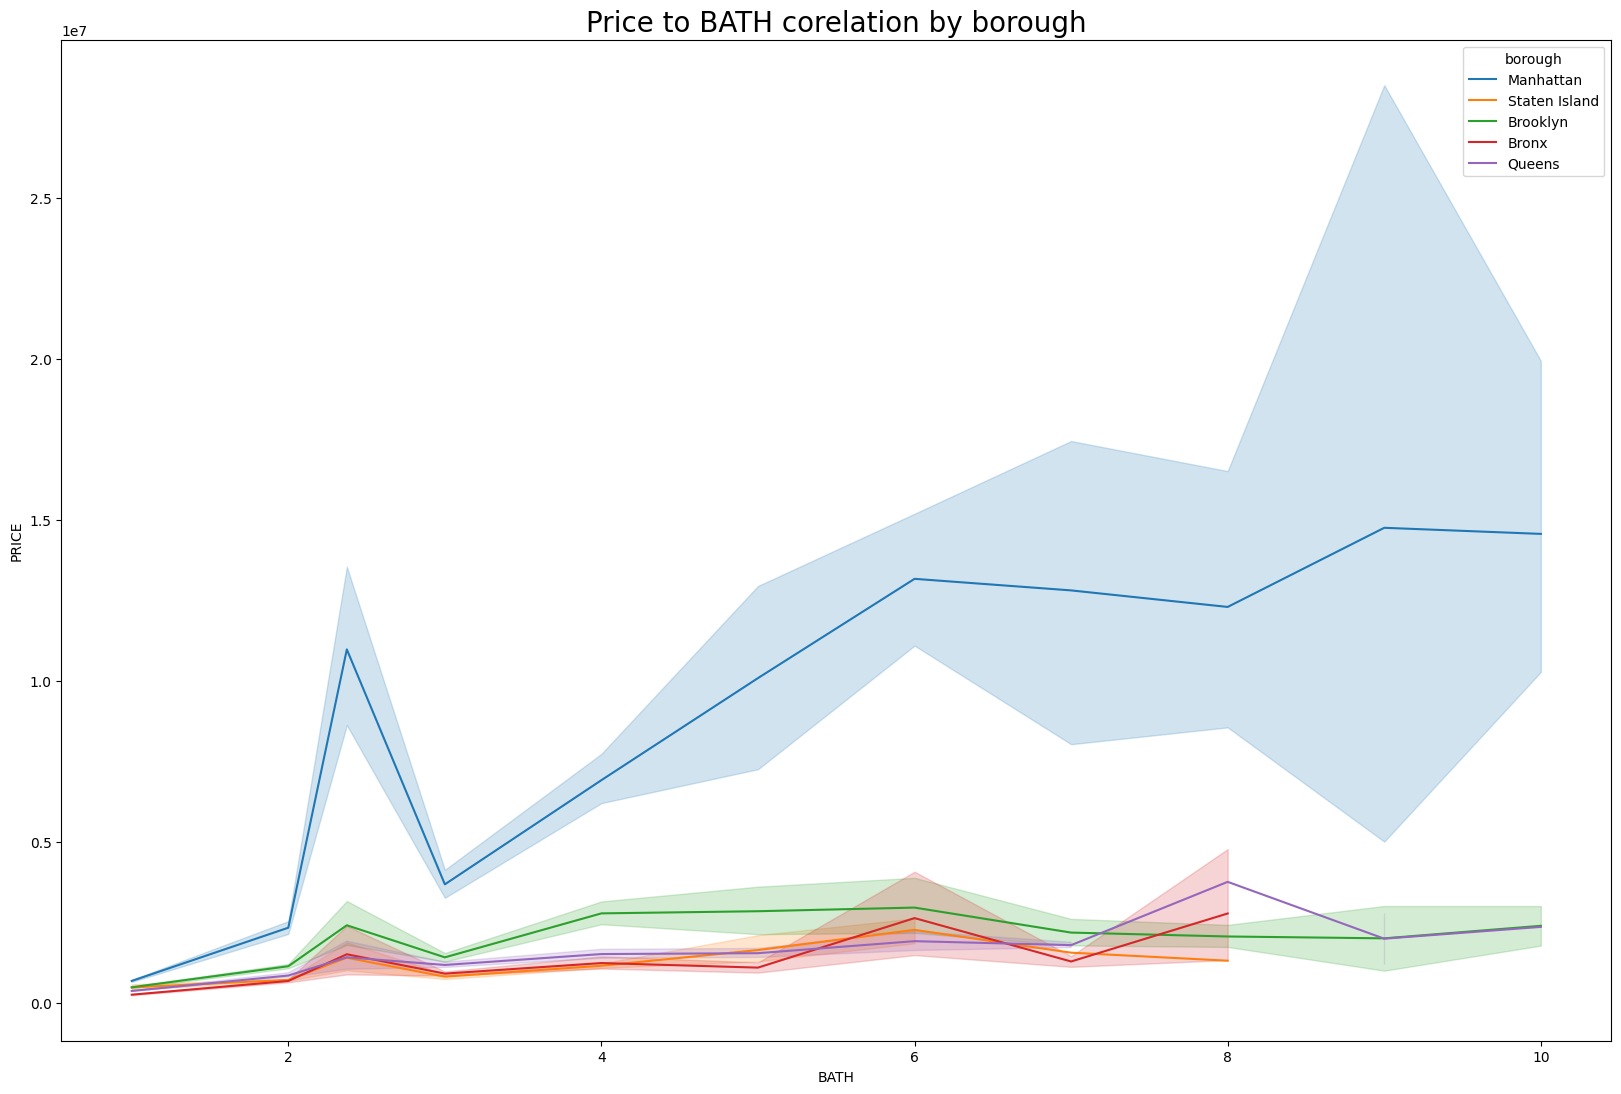

In [1037]:
labels = ["PROPERTYSQFT", "BEDS", "BATH"]
for elem in labels:
    price_to_ratio(elem)

It is clear that generaly with increasing area footage, price go up as well in every borough.
It is clear that generaly with increasing number of beds, price go up as well in every borough.
It is clear that generaly with increasing number of baths, price go up as well in every borough.

Corelation of Beds and bath count to price in the entire city

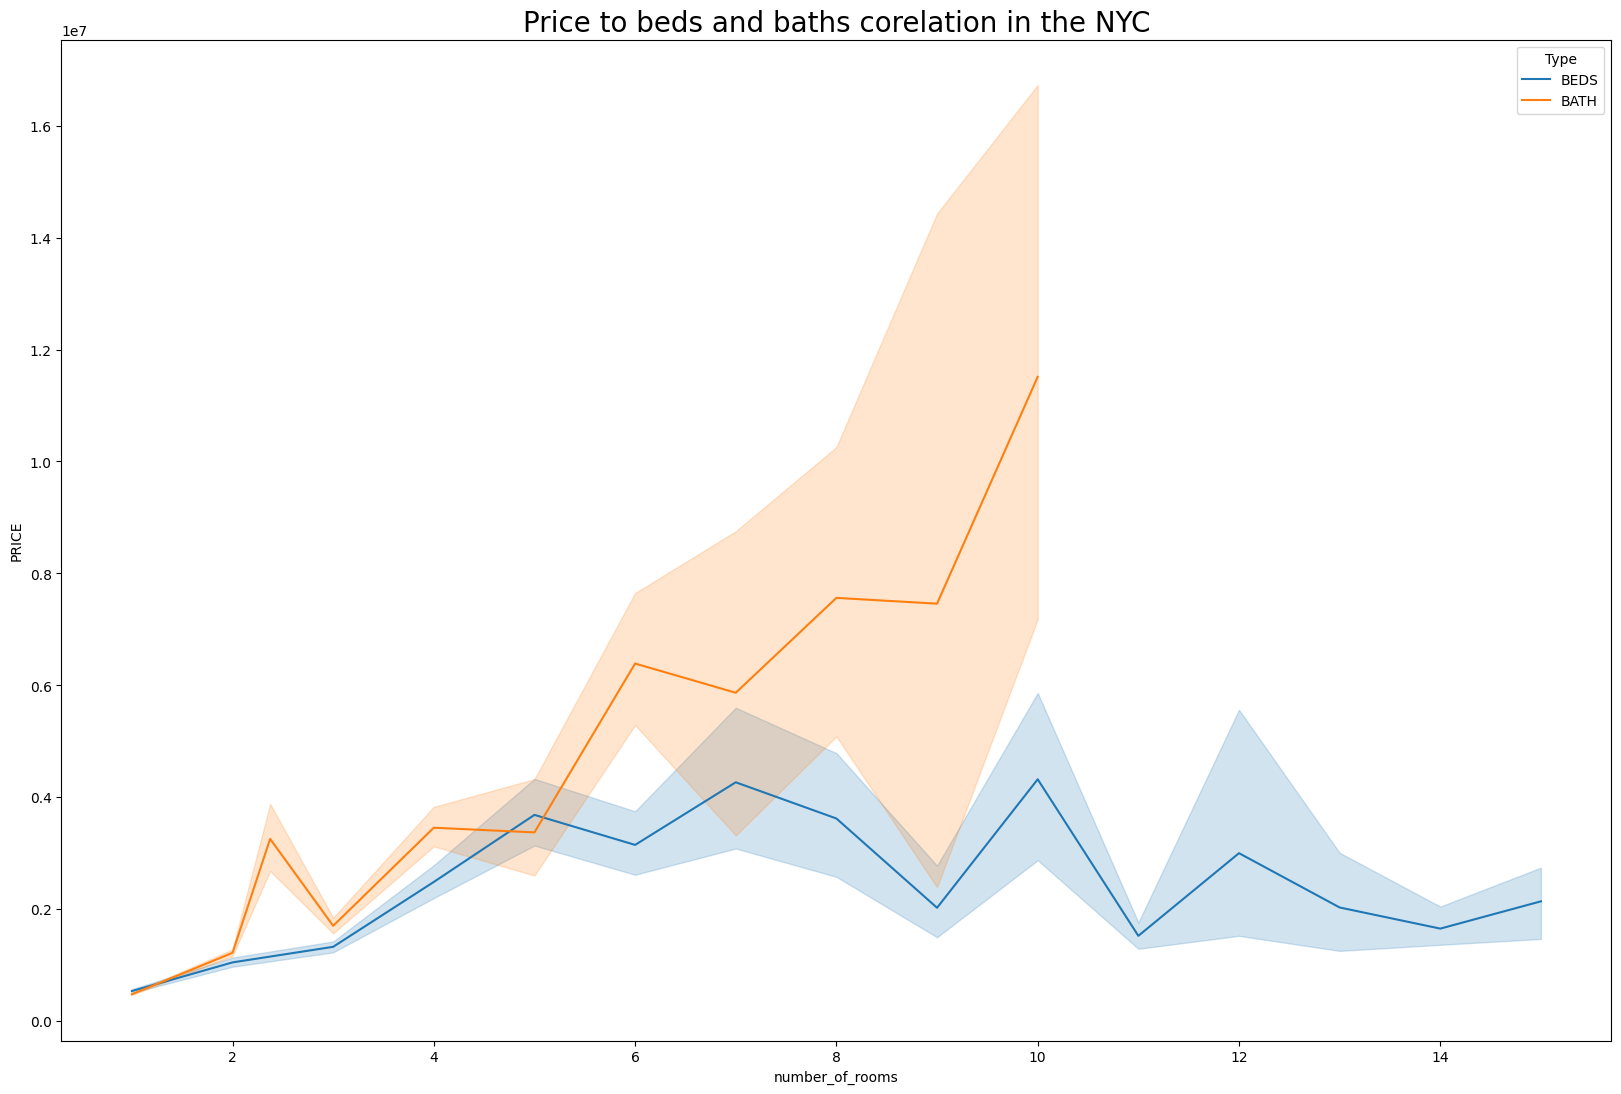

In [1038]:
def price_to_bd_bt() -> None:
    global data
    df = pd.DataFrame()
    tp = []
    price = []
    num = []
    for idx in range(data.shape[0]):
        cur = data.iloc[idx]
        tp.append("BEDS")
        price.append(cur['PRICE'])
        num.append(cur["BEDS"])
        tp.append("BATH")
        price.append(cur['PRICE'])
        num.append(cur["BATH"])
    df['Type'] = tp
    df['PRICE'] = price
    df['number_of_rooms'] = num
    plt.figure(1, figsize = (20,13))
    plt.title(f"Price to beds and baths corelation in the NYC", fontsize=20)
    sns.lineplot(data=df, x='number_of_rooms', y="PRICE", hue="Type")
    plt.show()

price_to_bd_bt()

We can see that in the NYC on average additional bathroom increases price more then additional bedroom.

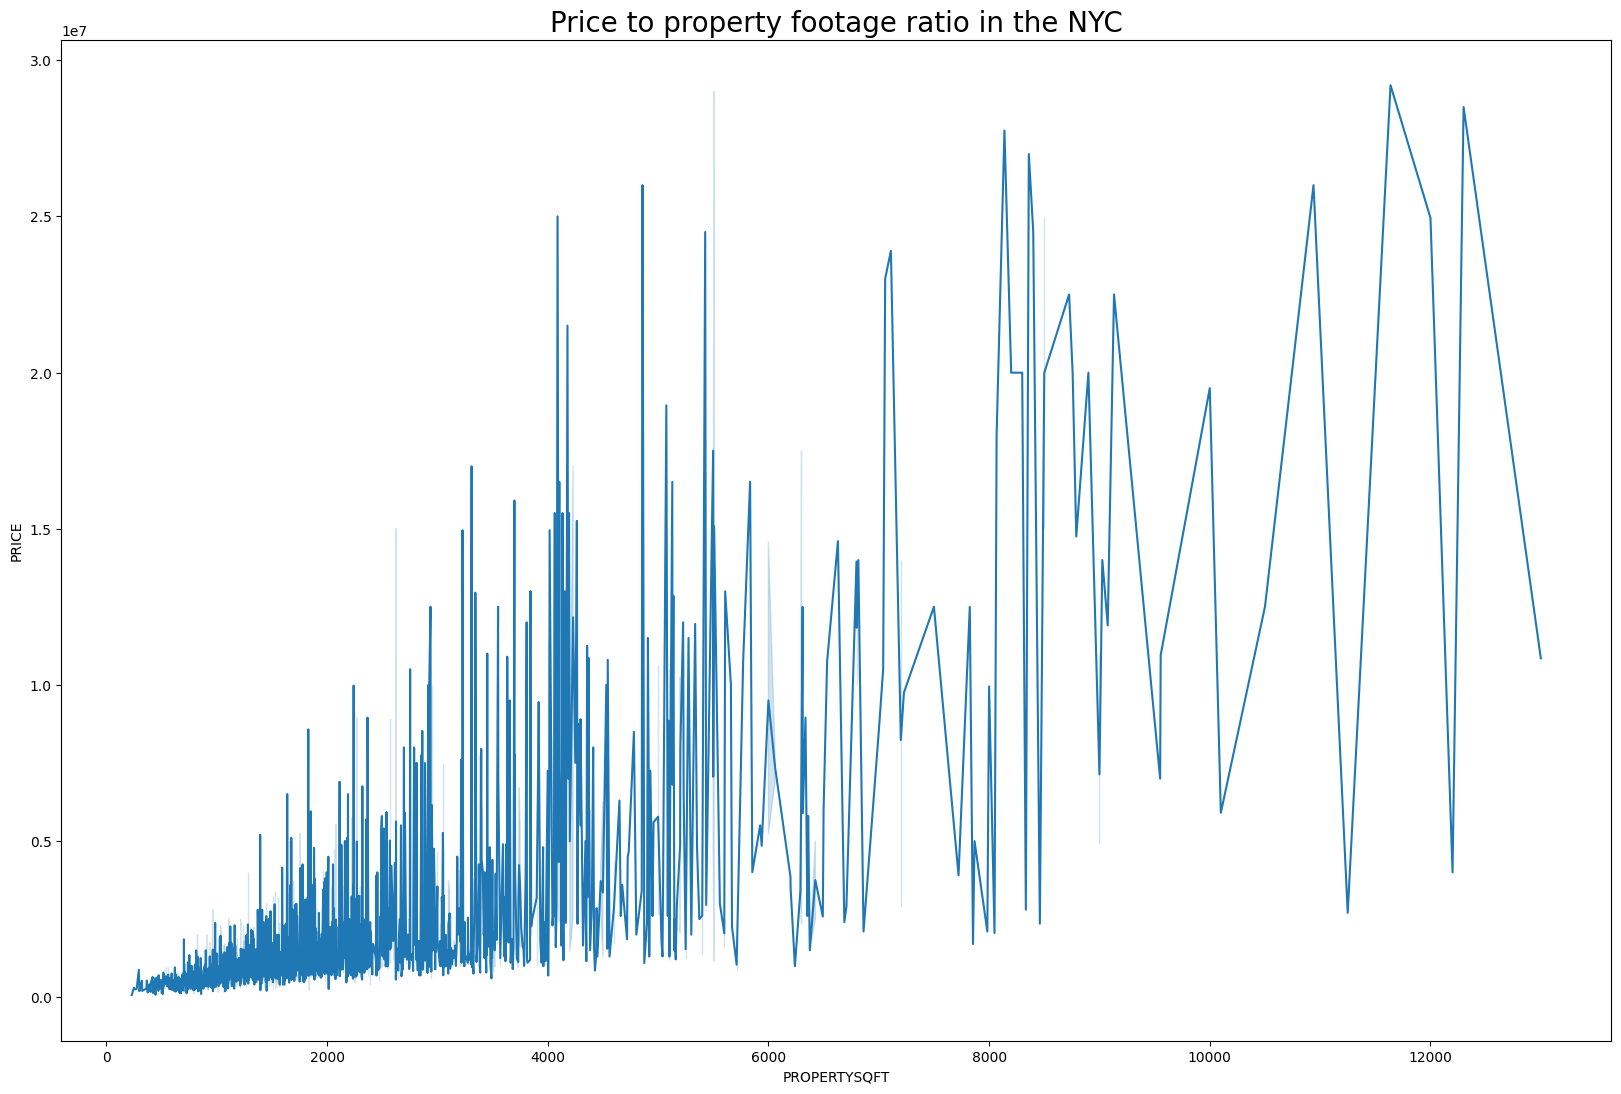

In [1039]:
def price_to_sqft() -> None:
    global data
    df = pd.DataFrame()
    price = []
    num = []
    for idx in range(data.shape[0]):
        cur = data.iloc[idx]
        price.append(cur['PRICE'])
        num.append(cur["PROPERTYSQFT"])
    df['PRICE'] = price
    df['PROPERTYSQFT'] = num
    plt.figure(1, figsize = (20,13))
    plt.title(f"Price to property footage ratio in the NYC", fontsize=20)
    sns.lineplot(data=df, x='PROPERTYSQFT', y="PRICE")
    plt.show()

price_to_sqft()

In general in the NYC property with bigger area footage tend to cost more

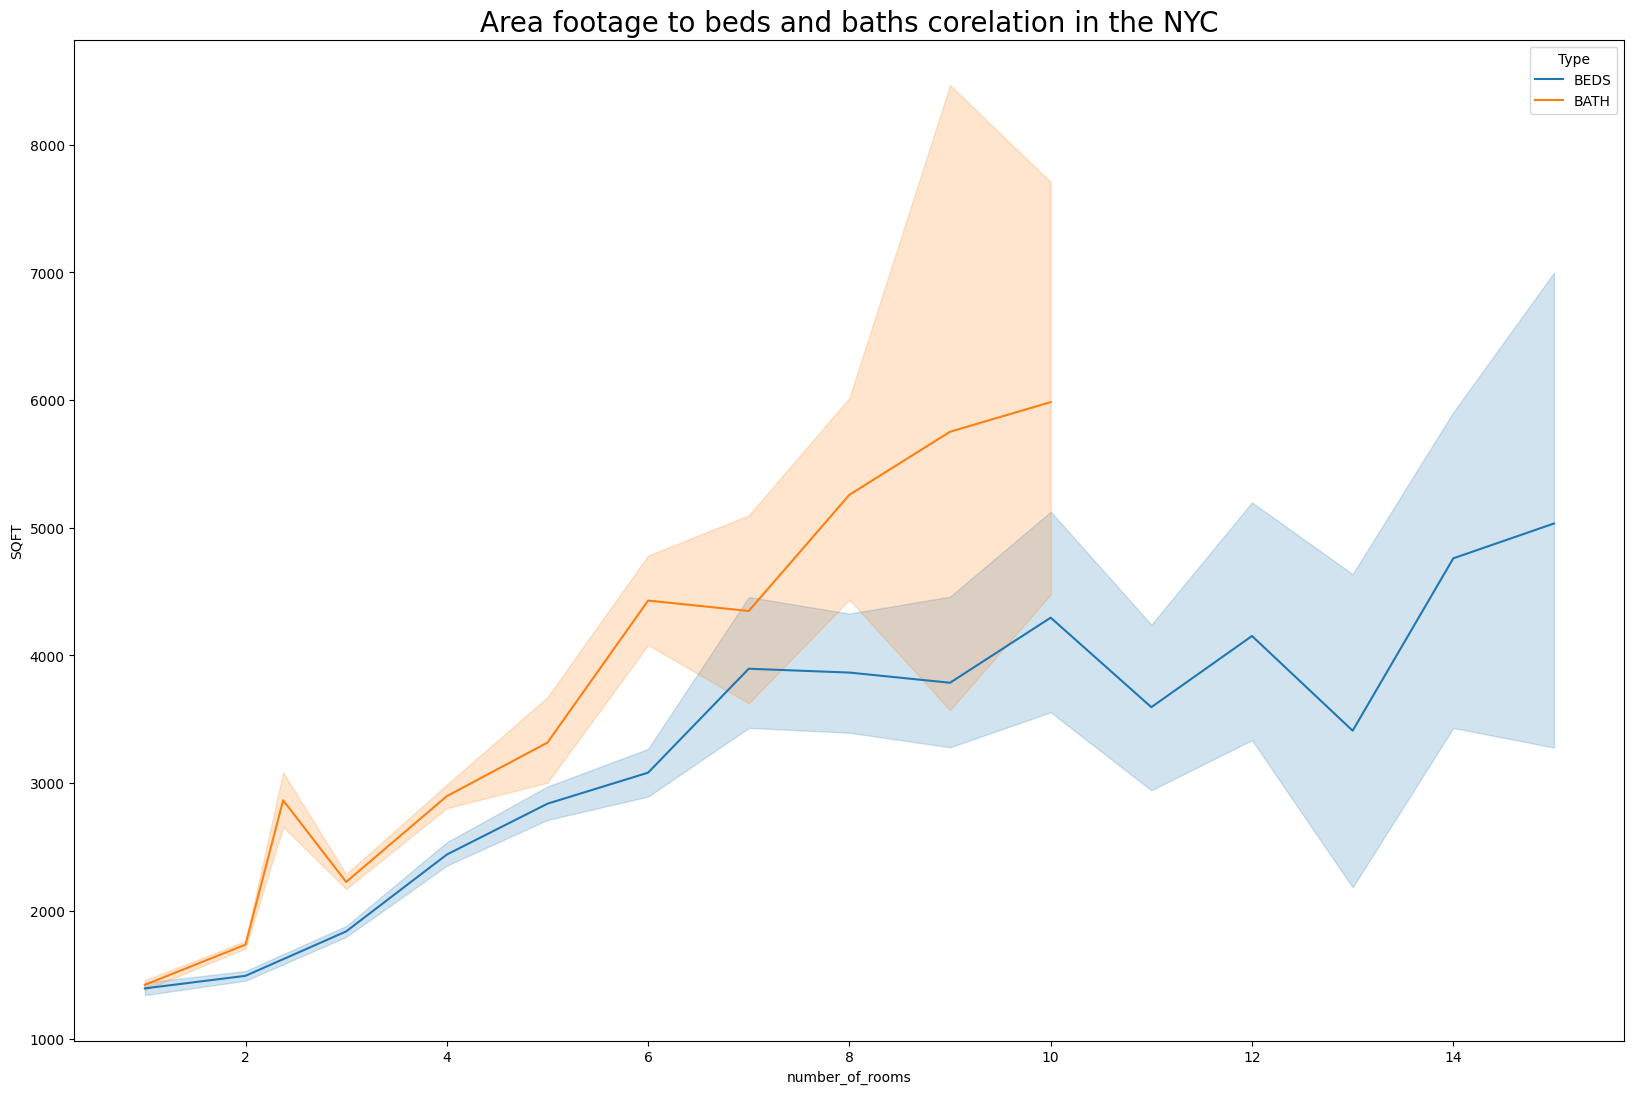

In [1040]:
def show_sqft_to_bd_and_bt() -> None:
    global data
    df = pd.DataFrame()
    tp = []
    sqft = []
    num = []
    for idx in range(data.shape[0]):
        cur = data.iloc[idx]
        tp.append("BEDS")
        sqft.append(cur['PROPERTYSQFT'])
        num.append(cur["BEDS"])
        tp.append("BATH")
        sqft.append(cur['PROPERTYSQFT'])
        num.append(cur["BATH"])
    df['Type'] = tp
    df['SQFT'] = sqft
    df['number_of_rooms'] = num
    plt.figure(1, figsize = (20,13))
    plt.title(f"Area footage to beds and baths corelation in the NYC", fontsize=20)
    sns.lineplot(data=df, x='number_of_rooms', y="SQFT", hue="Type")
    plt.show()

show_sqft_to_bd_and_bt()

It shows that in general the more space you have the more rooms you have.

Visualization of median prices

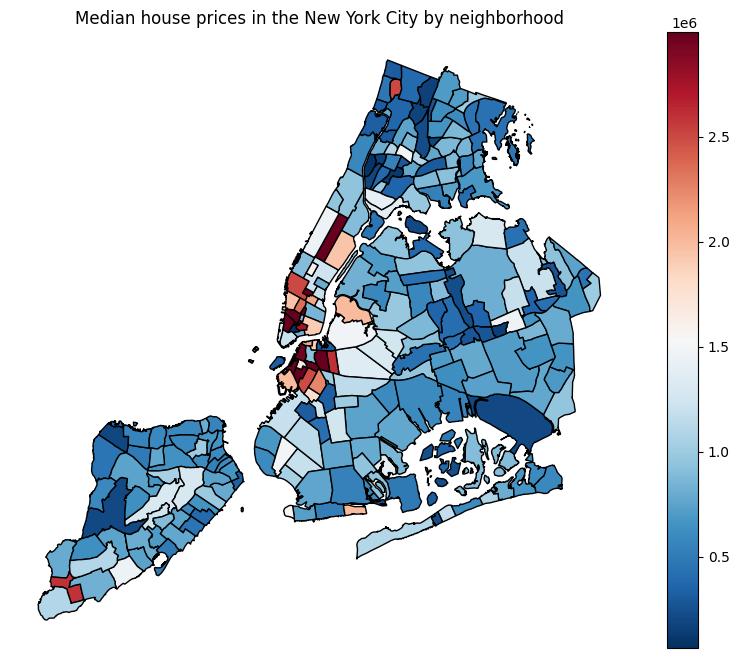

In [1041]:
fig, gax = plt.subplots(figsize = (10,8))

nyc_map.plot(
    ax=gax, edgecolor='black', column='median_price', legend=True, cmap='RdBu_r',
    vmin=medianprices[0][0], vmax=medianprices[-1][0]/3
)

plt.title('Median house prices in the New York City by neighborhood')
plt.axis('off')

plt.show()

This map shows us which neighborhoods are more expensive to buy an apartment in. It is also seen that the most expesive boroughs are Manhattan and Brooklyn, while the cheapest one is Bronx.

Creating prediction model

In [1042]:
train_dt = data.iloc[:4500, :]
test_dt = data.iloc[4500:, :]
train_d = dict()
mn = 100
for elem in list(neighborhood_id.keys())[1:]:
    if (train_dt[train_dt.neighborhood == neighborhood_id[elem]].shape[0] < 2):
        continue
    train_d[neighborhood_id[elem]] = train_dt[train_dt.neighborhood == neighborhood_id[elem]]
model = dict()
for elem in list(train_d.keys()):
    md = linear_model.LinearRegression()
    md1 = linear_model.LinearRegression()
    X_t = train_d[elem][['PROPERTYSQFT']]
    Y_t = train_d[elem][['PRICE']]
    X_t1 = train_d[elem][['BEDS', 'BATH']]
    Y_t1 = train_d[elem][['PRICE']]
    md.fit(X_t, Y_t)
    md1.fit(X_t1, Y_t1)
    model[elem] = (md, md1)

In [1043]:
def predict(beds: float, baths: float, sqft: float, nb: int) -> float:
    global model
    try:
        p = float(model[nb][0].predict(np.array([[sqft]]))[0])
        p1 = float(model[nb][1].predict(np.array([[beds, baths]]))[0])
        return ((p * 0.9 + p1 * 0.1))
    except:
        return randint(30000000, 60000000) / 100

Testing single data point

In [1044]:
predict(2, 2, 1400, 257)

/Users/ilyamaranin/Library/Python/3.9/lib/python/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
/var/folders/qr/2jlr58g918dgpbmnf7w1dv140000gn/T/ipykernel_76725/4112396798.py:4: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  p = float(model[nb][0].predict(np.array([[sqft]]))[0])
/Users/ilyamaranin/Library/Python/3.9/lib/python/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
/var/folders/qr/2jlr58g918dgpbmnf7w1dv140000gn/T/ipykernel_76725/4112396798.py:5: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from you

1296771.2859945544

Check deviation on the rest of the data

In [1045]:
def check() -> None:
    global test_dt
    dev = 0
    num = 0
    for idx in range(test_dt.shape[0]):
        cur = test_dt.iloc[idx]
        prediction = predict(cur['BEDS'], cur['BATH'], cur['PROPERTYSQFT'], cur['neighborhood'])
        dev = cur['PRICE'] - prediction
        num += 1
    print(f'Average deviation : {dev / num}')

check()

Average deviation : -178.642775103457


/Users/ilyamaranin/Library/Python/3.9/lib/python/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
/var/folders/qr/2jlr58g918dgpbmnf7w1dv140000gn/T/ipykernel_76725/4112396798.py:4: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  p = float(model[nb][0].predict(np.array([[sqft]]))[0])
/Users/ilyamaranin/Library/Python/3.9/lib/python/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
/var/folders/qr/2jlr58g918dgpbmnf7w1dv140000gn/T/ipykernel_76725/4112396798.py:5: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from you

This survey shows that while there might be a big deviation in price prediction for a single house, but when we concider more houses deviation seems to be very low.

Adding a new parametr to the dataset

In [1046]:
price_per_sqft = []
for idx in range(data.shape[0]):
    price_per_sqft.append(data.iloc[idx]['PRICE'] / data.iloc[idx]['PROPERTYSQFT'])
data['PRICE_PER_SQFT'] = price_per_sqft
data.head()

,PRICE,BEDS,BATH,PROPERTYSQFT,neighborhood,PRICE_PER_SQFT
0,315000,2,2.0,1400.000000,257,225.000000
2,260000,4,2.0,2015.000000,244,129.032258
3,69000,3,1.0,445.000000,257,155.056180
5,690000,5,2.0,4004.000000,249,172.327672
6,899500,2,2.0,2184.207862,226,411.819779


In [1047]:
def mean_price_per_sqft(br: str) -> float:
    global data
    global id_to_n
    global borough
    pr = 0
    num = 0
    for idx in range(data.shape[0]):
        cur = data.iloc[idx]
        if (borough[id_to_n[cur['neighborhood']]] == br) :
            pr += cur['PRICE_PER_SQFT']
            num += 1
    return float(pr / num)

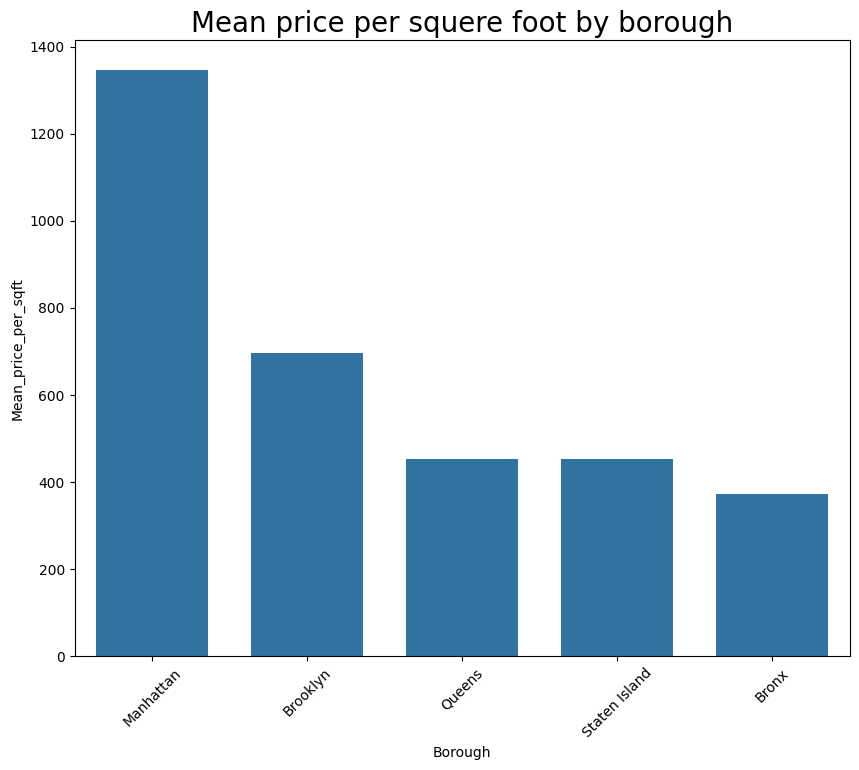

In [1048]:
def show_neam_price_by_sqft() -> None: 
    labels = ['Manhattan', 'Brooklyn', 'Queens', 'Staten Island', 'Bronx']
    df = pd.DataFrame()
    num = []
    for elem in labels:
        num.append(mean_price_per_sqft(elem))
    df['Borough'] = labels
    df['Mean_price_per_sqft'] = num
    plt.figure(1, figsize = (10,8))
    plt.title("Mean price per squere foot by borough", fontsize=20)
    p = sns.barplot(data=df, x='Borough', y='Mean_price_per_sqft', fill=True, gap=0.1)
    p.tick_params(axis='x', rotation=45)
    plt.show()

show_neam_price_by_sqft()

It shows that prices per SQFT tend to be the highest on Manhattan and the lowest in Bronx.

Conclusion: in general the more you have beds/baths/squere foot in your appartment, the higher the price is, also apartments in neghborhoods whith higher median price tend to cost more.

Saving all relevant information for model

In [1049]:
data.to_csv('reviewed_dataset.csv', encoding='utf-8', index=False, header=True)

In [1050]:
with open("neighborhood.pkl", 'wb') as f:
    pickle.dump(neighborhood_id, f)